# Occupancy detection
Data set obtained from http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+# 

The objective is to create a model that can predict occupancy of a room given measurements of temperature, humidity, light intensity, CO2 and Humidity Ratio.

Let's compare logistic regression and simple NN and then change the topology of the NN to increase hidden layers (deep learning)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from dateutil import parser
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.core.pylabtools import figsize

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
def plot_loss_accuracy(history):
    df = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(10, 10))
    df.plot(ylim=(0, max(1, df.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [3]:
def plot_confusion_matrix(X, y, y_pred):
    #y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(10, 10))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

In [4]:
train = pd.read_csv('./Data/occupancy_data/datatraining.txt')
test = pd.read_csv('./Data/occupancy_data/datatest.txt')
test2 = pd.read_csv('./Data/occupancy_data/datatest2.txt')

In [5]:
train.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
7206,2015-02-09 17:55:59,22.1000,37.9750,433.0,1839.25,0.006265,1
2973,2015-02-06 19:23:00,20.6000,19.3400,0.0,523.00,0.002895,0
5871,2015-02-08 19:40:59,19.2900,27.7000,0.0,435.00,0.003829,0
4680,2015-02-07 23:50:00,19.6000,29.2900,0.0,437.00,0.004129,0
7881,2015-02-10 05:10:59,20.1500,33.0000,0.0,446.50,0.004819,0
4807,2015-02-08 01:57:00,19.5000,30.6000,0.0,437.75,0.004288,0
4214,2015-02-07 16:04:00,21.2000,19.2000,36.5,437.50,0.002982,0
1366,2015-02-05 16:36:00,22.3900,26.0150,444.0,1056.25,0.004355,1
333,2015-02-04 23:23:00,21.2000,25.3900,0.0,471.00,0.003950,0
8098,2015-02-10 08:48:00,20.4175,33.5675,408.0,499.00,0.004985,1


In [6]:
all_data = train.append(test)
all_data = all_data.append(test2)
all_data.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2815,2015-02-13 13:41:59,23.722500,25.972500,664.750000,567.750000,0.004716,0
9444,2015-02-18 04:11:00,20.790000,26.100000,0.000000,1414.000000,0.003959,0
3978,2015-02-14 09:04:59,19.926667,36.500000,6.000000,502.333333,0.005260,0
5235,2015-02-08 09:04:59,19.290000,31.100000,35.000000,434.500000,0.004302,0
7685,2015-02-16 22:52:00,20.390000,30.200000,0.000000,715.500000,0.004473,0
1134,2015-02-05 12:43:59,22.650000,26.550000,521.000000,1051.000000,0.004517,1
6832,2015-02-09 11:42:00,21.390000,33.272500,479.000000,1444.750000,0.005248,1
2520,2015-02-06 11:50:00,21.633333,20.323333,460.666667,790.666667,0.003243,1
1938,2015-02-03 20:17:00,21.200000,27.290000,0.000000,725.400000,0.004248,0
1758,2015-02-05 23:08:00,20.500000,21.290000,0.000000,451.000000,0.003168,0


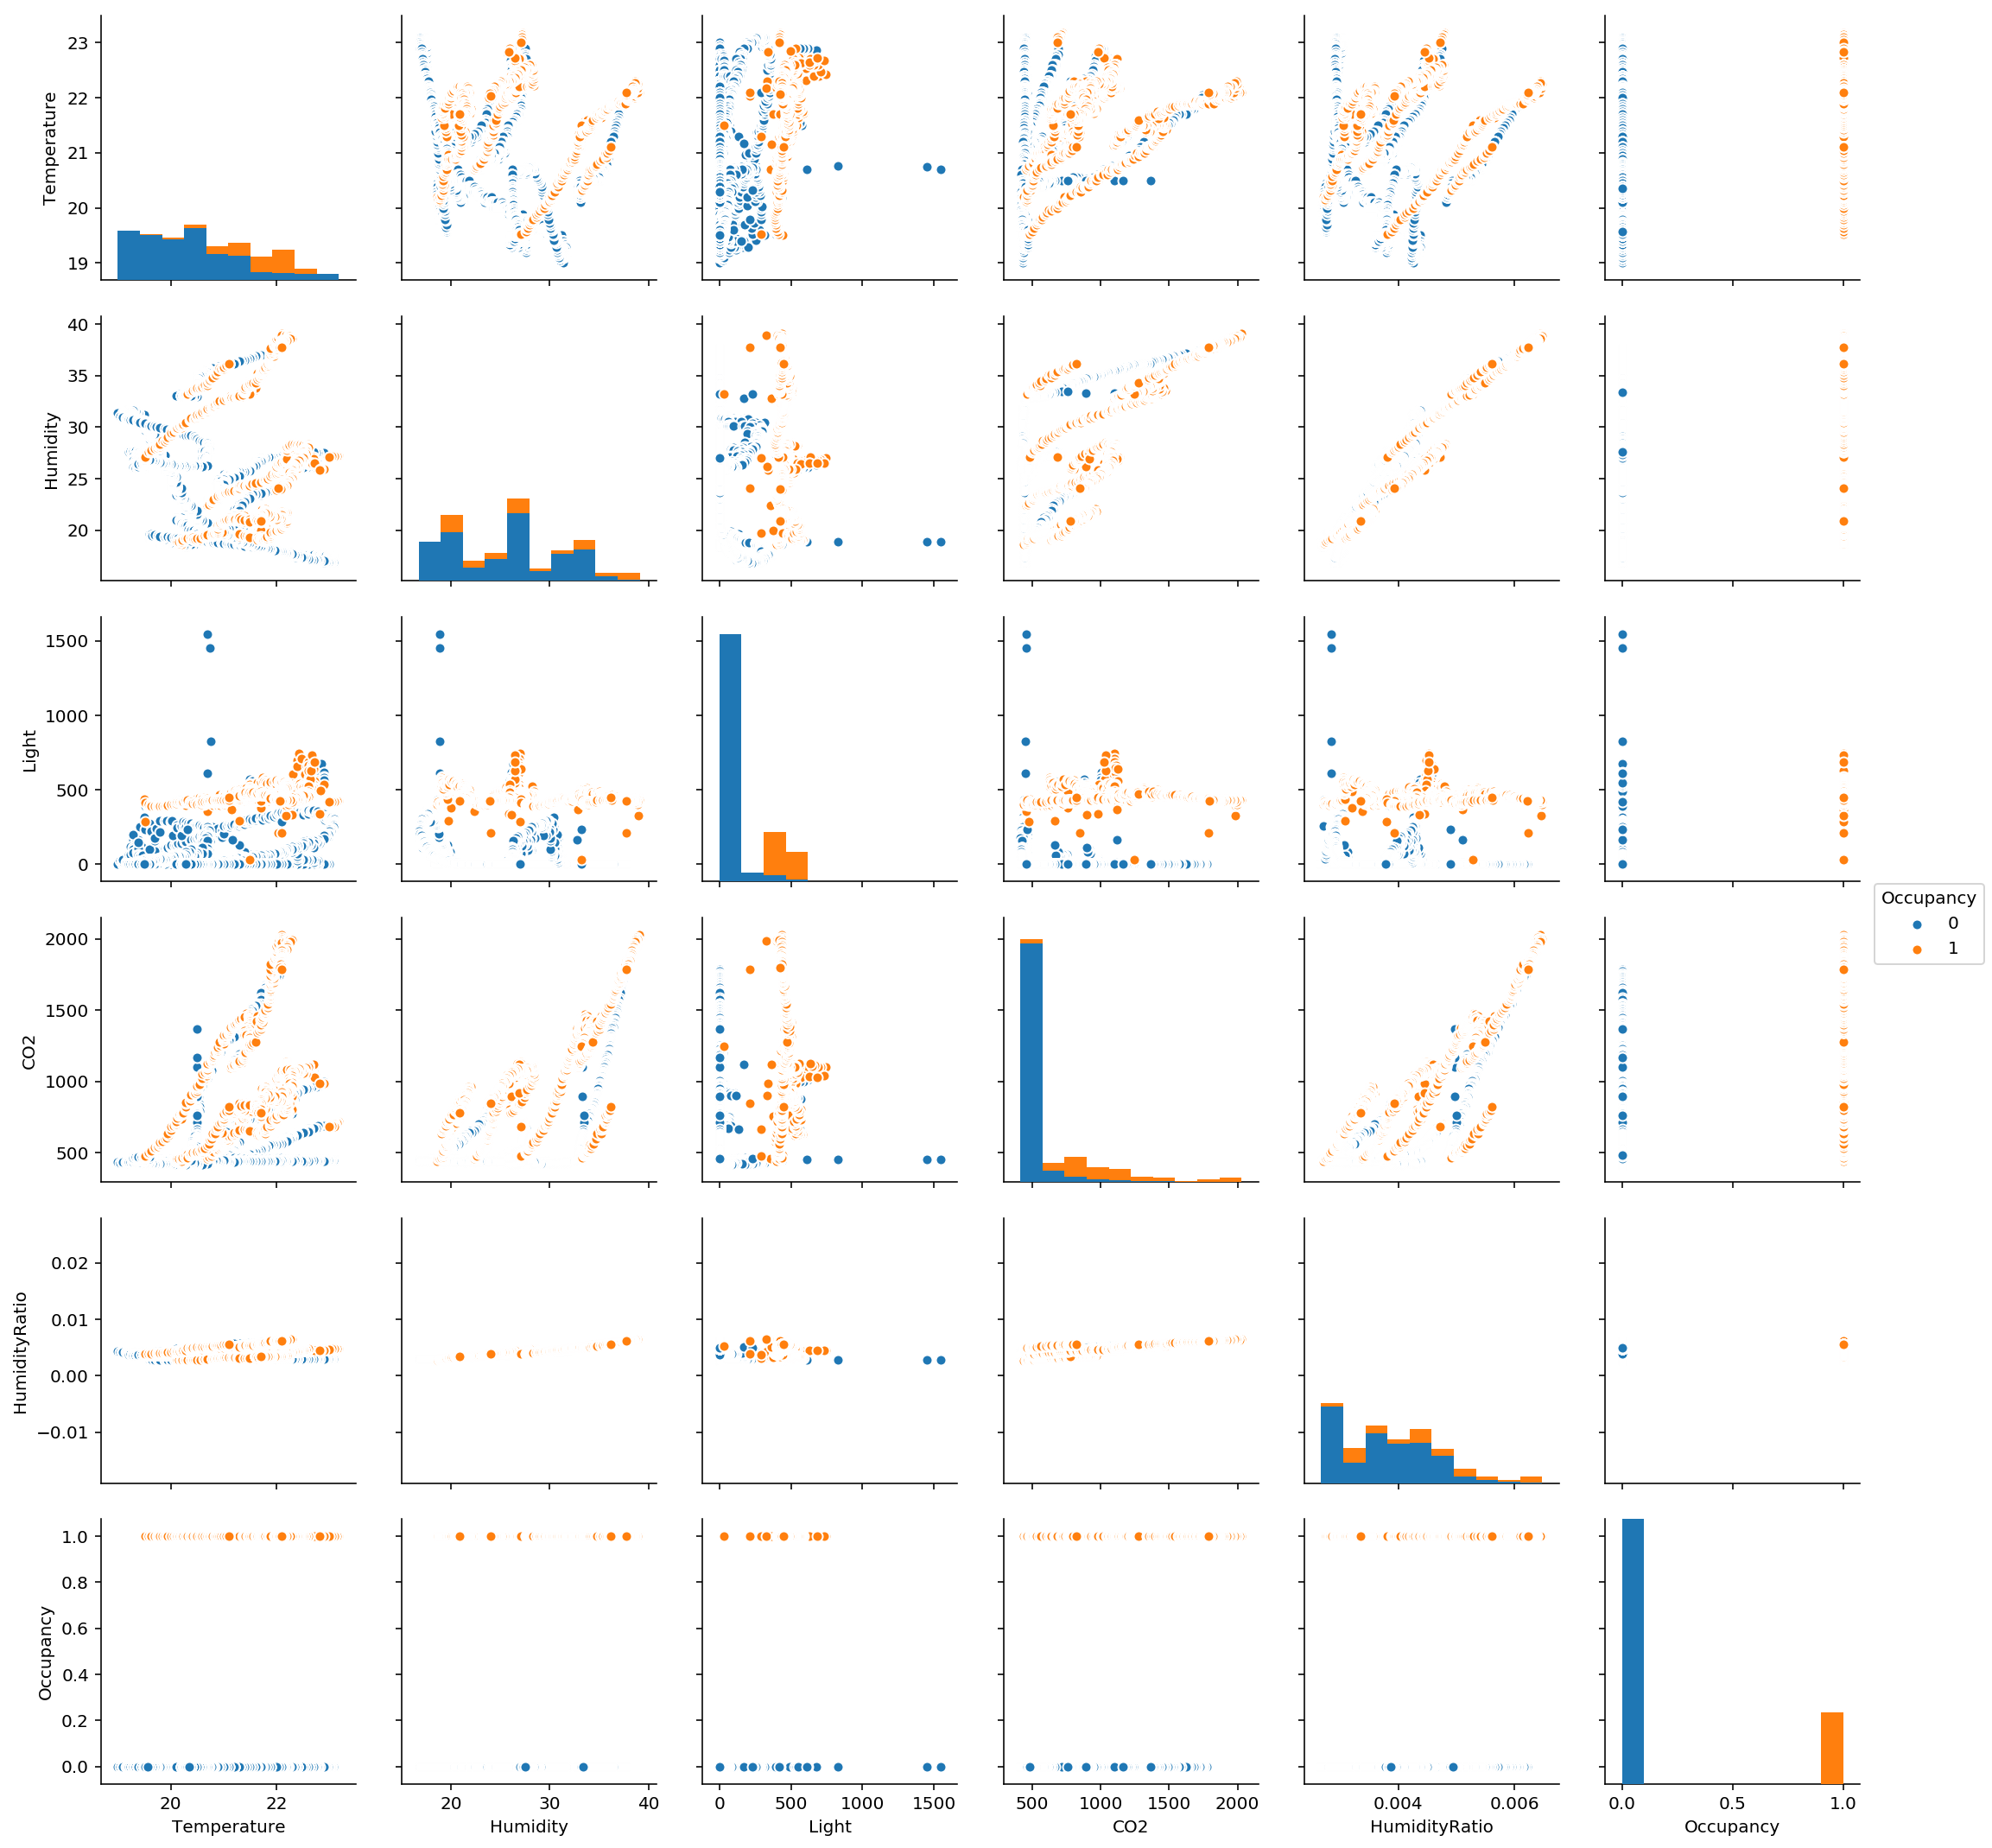

In [7]:
sns.pairplot(train, hue='Occupancy')

In [8]:
c = train.drop('Occupancy', axis=1).corr().abs()

s = c.unstack()
print(type(s))
so = s.sort_values(ascending=False, kind="quicksort")
print(so)

<class 'pandas.core.series.Series'>
HumidityRatio  HumidityRatio    1.000000
CO2            CO2              1.000000
Humidity       Humidity         1.000000
Light          Light            1.000000
Temperature    Temperature      1.000000
HumidityRatio  Humidity         0.955198
Humidity       HumidityRatio    0.955198
Light          CO2              0.664022
CO2            Light            0.664022
Temperature    Light            0.649942
Light          Temperature      0.649942
HumidityRatio  CO2              0.626556
CO2            HumidityRatio    0.626556
               Temperature      0.559894
Temperature    CO2              0.559894
Humidity       CO2              0.439023
CO2            Humidity         0.439023
Light          HumidityRatio    0.230420
HumidityRatio  Light            0.230420
Temperature    HumidityRatio    0.151762
HumidityRatio  Temperature      0.151762
Humidity       Temperature      0.141759
Temperature    Humidity         0.141759
Light          Humidi

Quick insights from the plots (and table) above:
- Humidity and Humidity ratio seem to be highly corralated to each other (not independent). We might not need these two features for our ML model
- The pairs (CO2 <-> Ligth) and (Light <-> Temperature) show distint clusters of Occupancy status that look linearly separable

In [9]:
train['date'] = np.array([parser.parse(x) for x in train['date'].values])
time_secs = train['date'].dt.hour*3600+train['date'].dt.minute*60 + train['date'].dt.second

# Do the same for the test data set... nothing we are not manipulating the data... just adding features for time
all_data['date'] = np.array([parser.parse(x) for x in all_data['date'].values])
test_secs = all_data['date'].dt.hour*3600+all_data['date'].dt.minute*60 + all_data['date'].dt.second

We need a transformation for time, we will be assuming a cycle of 24 hours since training data is less than one week. If more training data is available then we can look at occupancy at different time cycles (days, weeks, months, etc). Thus, at the moment we want to only explore if occupancy varies based on the time of the day

In [10]:
sec_day = 24*60*60

train['sin_time'] = np.sin(2*np.pi*time_secs/sec_day)
train['cos_time'] = np.cos(2*np.pi*time_secs/sec_day)

all_data['sin_time'] = np.sin(2*np.pi*test_secs/sec_day)
all_data['cos_time'] = np.cos(2*np.pi*test_secs/sec_day)

train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_time,cos_time
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,-0.999229,-0.039260
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,-0.999388,-0.034972
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,-0.999534,-0.030539
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,-0.999657,-0.026177
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,-0.999762,-0.021815


In [11]:
train.set_index('date', inplace=True)
all_data.set_index('date', inplace=True)

In [12]:
train.head(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_time,cos_time
date,,,,,,,,
2015-02-04 17:51:00,23.180,27.2720,426.0,721.250000,0.004793,1,-0.999229,-3.925982e-02
2015-02-04 17:51:59,23.150,27.2675,429.5,714.000000,0.004783,1,-0.999388,-3.497217e-02
2015-02-04 17:53:00,23.150,27.2450,426.0,713.500000,0.004779,1,-0.999534,-3.053851e-02
2015-02-04 17:54:00,23.150,27.2000,426.0,708.250000,0.004772,1,-0.999657,-2.617695e-02
2015-02-04 17:55:00,23.100,27.2000,426.0,704.500000,0.004757,1,-0.999762,-2.181489e-02
2015-02-04 17:55:59,23.100,27.2000,419.0,701.000000,0.004757,1,-0.999846,-1.752512e-02
2015-02-04 17:57:00,23.100,27.2000,419.0,701.666667,0.004757,1,-0.999914,-1.308960e-02
2015-02-04 17:57:59,23.100,27.2000,419.0,699.000000,0.004757,1,-0.999961,-8.799255e-03
2015-02-04 17:58:59,23.100,27.2000,419.0,689.333333,0.004757,1,-0.999990,-4.436031e-03


In [13]:
all_data.sample(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,sin_time,cos_time
date,,,,,,,,
2015-02-12 12:35:00,24.200000,22.70,248.50,725.000000,0.004238,0,-0.152123,-0.988362
2015-02-08 01:32:00,19.533333,30.10,0.00,439.666667,0.004226,0,0.390731,0.920505
2015-02-12 04:31:00,20.700000,23.70,0.00,558.000000,0.003573,0,0.925541,0.378649
2015-02-09 06:07:00,19.500000,26.65,0.00,459.000000,0.003731,0,0.999534,-0.030539
2015-02-06 09:52:00,21.290000,21.00,444.00,812.333333,0.003282,1,0.529919,-0.848048
2015-02-08 06:10:59,19.245000,31.65,0.00,437.500000,0.004366,0,0.998852,-0.047905
2015-02-15 19:27:59,20.390000,32.70,0.00,664.333333,0.004847,0,-0.927211,0.374539
2015-02-08 02:02:00,19.445000,30.65,0.00,440.000000,0.004280,0,0.507538,0.861629
2015-02-08 13:59:59,20.700000,26.65,128.75,412.750000,0.004021,0,-0.499937,-0.866062


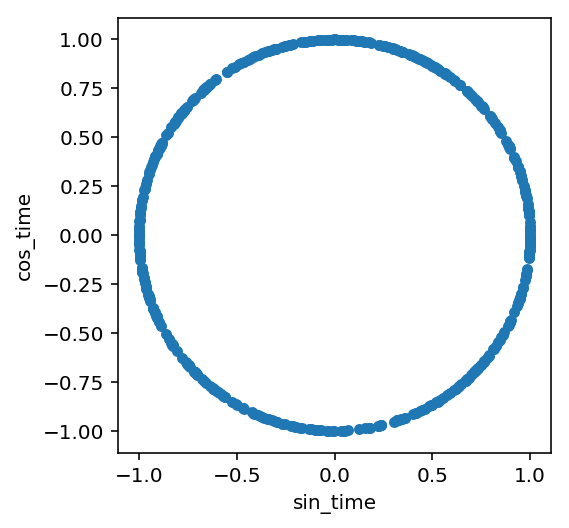

In [14]:
train.sample(500).plot.scatter('sin_time','cos_time').set_aspect('equal')

In [15]:
train.head(2).values

array([[ 2.31800000e+01,  2.72720000e+01,  4.26000000e+02,
         7.21250000e+02,  4.79298818e-03,  1.00000000e+00,
        -9.99229036e-01, -3.92598158e-02],
       [ 2.31500000e+01,  2.72675000e+01,  4.29500000e+02,
         7.14000000e+02,  4.78344095e-03,  1.00000000e+00,
        -9.99388286e-01, -3.49721744e-02]])

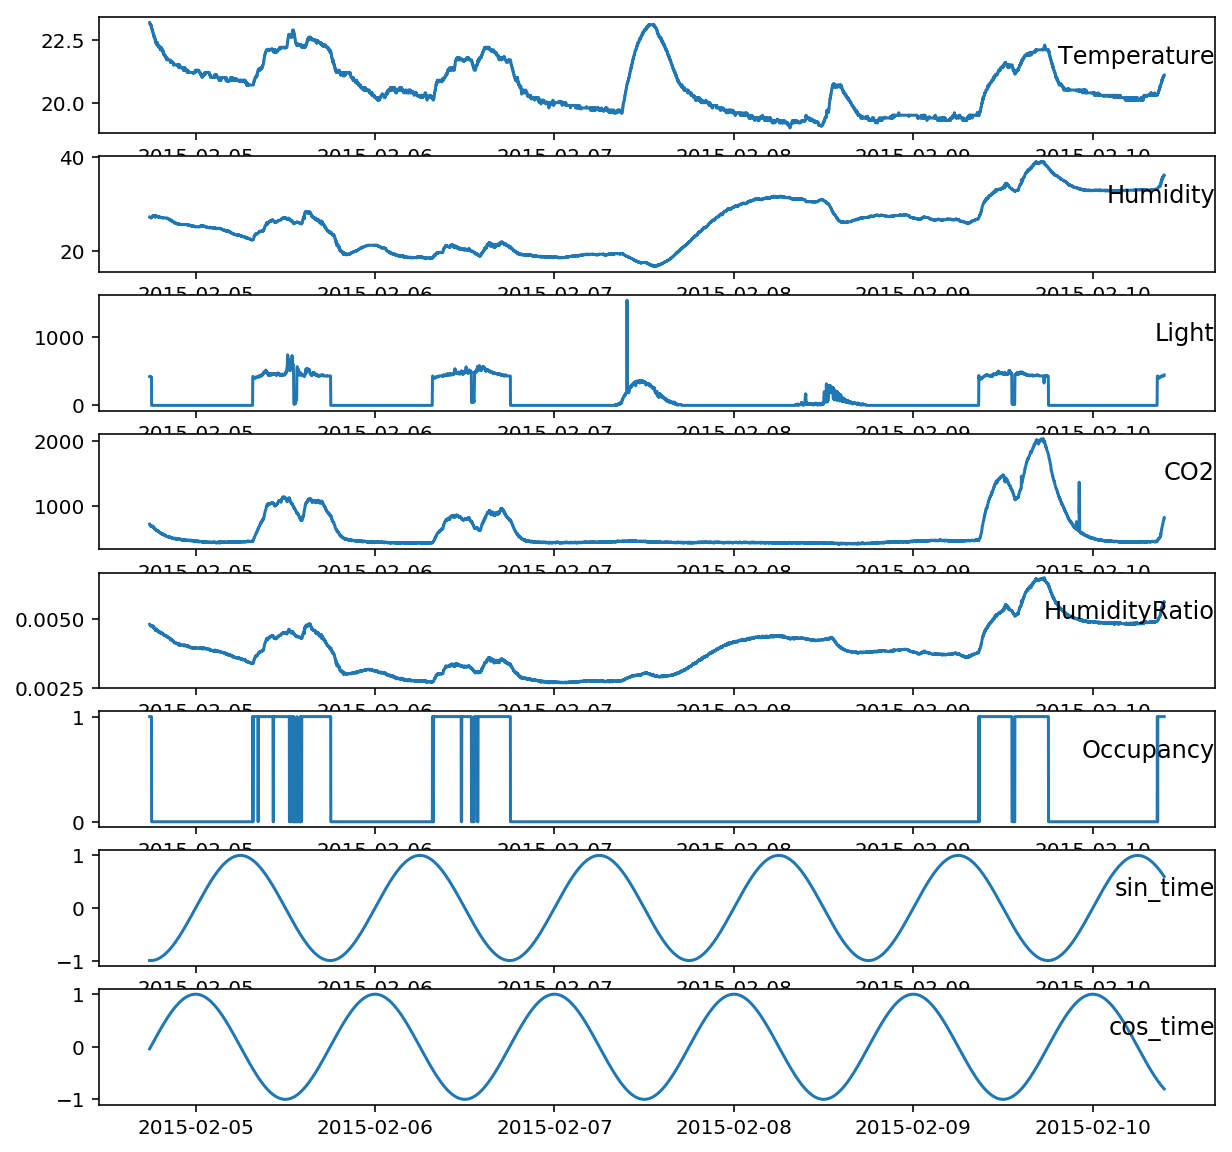

In [16]:
figsize(10,10)
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(train.index,train.values[:, group])
    plt.title(train.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [17]:
# figsize(10,10)
# # plot each column
# plt.figure()
# plt.plot(all_data.index,all_data.values[:, 5])
# plt.title(all_data.columns[5], y=0.5, loc='right')
# plt.show()

In [18]:
X_train = train.drop(['Occupancy', 'HumidityRatio'], axis=1).values
# X_train = train.drop(['Occupancy'], axis=1).values
y_train = train['Occupancy'].values

X_test = all_data.drop(['Occupancy', 'HumidityRatio'], axis=1).values
# X_test = test.drop(['Occupancy'], axis=1).values
y_test = all_data['Occupancy'].values


# Normalizing features

In [19]:
scaler_sig = MinMaxScaler(feature_range=(0, 1))
scaled_sig = scaler_sig.fit_transform(X_train)
scaler_tanh = MinMaxScaler(feature_range=(-1, 1))
scaled_tanh = scaler_tanh.fit_transform(X_train)

scaled_test_sig = scaler_sig.fit_transform(X_test)
scaled_test_tanh = scaler_tanh.fit_transform(X_test)

# Linear Regression

In [20]:
lr = LogisticRegression()
lr.fit(scaled_sig, y_train)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

LR coefficients: [[-1.69481671 -0.76932301 18.15291773  7.5689766   0.59948271 -0.82191802]]
LR intercept: [-4.26854397]


             precision    recall  f1-score   support

          0       0.98      0.98      0.98     15810
          1       0.93      0.92      0.93      4750

avg / total       0.97      0.97      0.97     20560

96.54182879377431


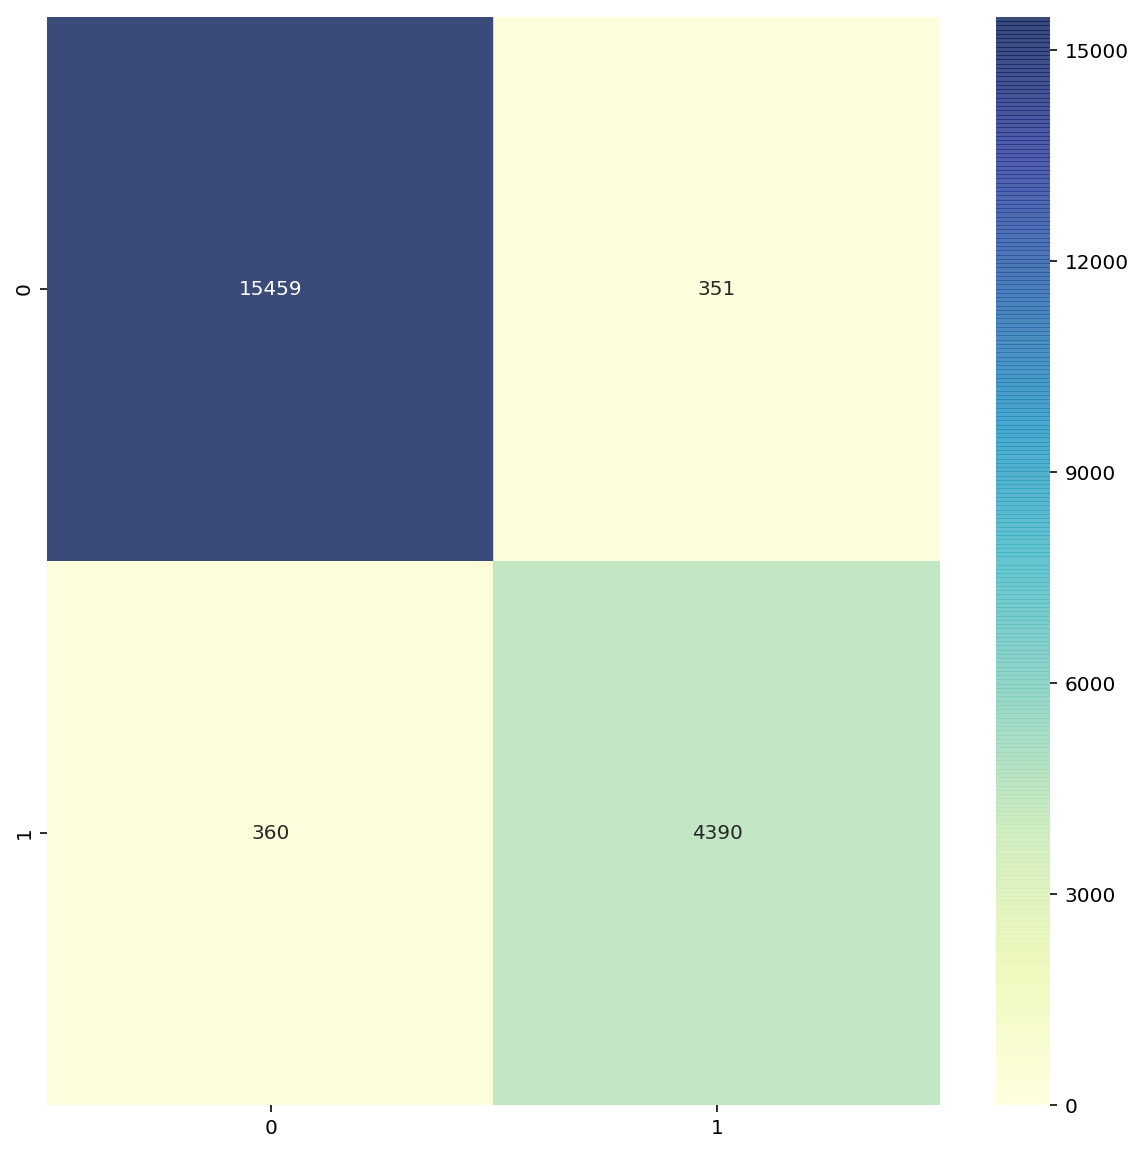

In [21]:
y_pred = lr.predict(scaled_test_sig)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(scaled_test_sig, y_test, y_pred)
score_lr = accuracy_score(y_test, y_pred)*100
print(score_lr)

Actually it is not that bad

# Neural networks
Let's see if we can do better with NN

# Shallow Model

<Figure size 720x720 with 0 Axes>

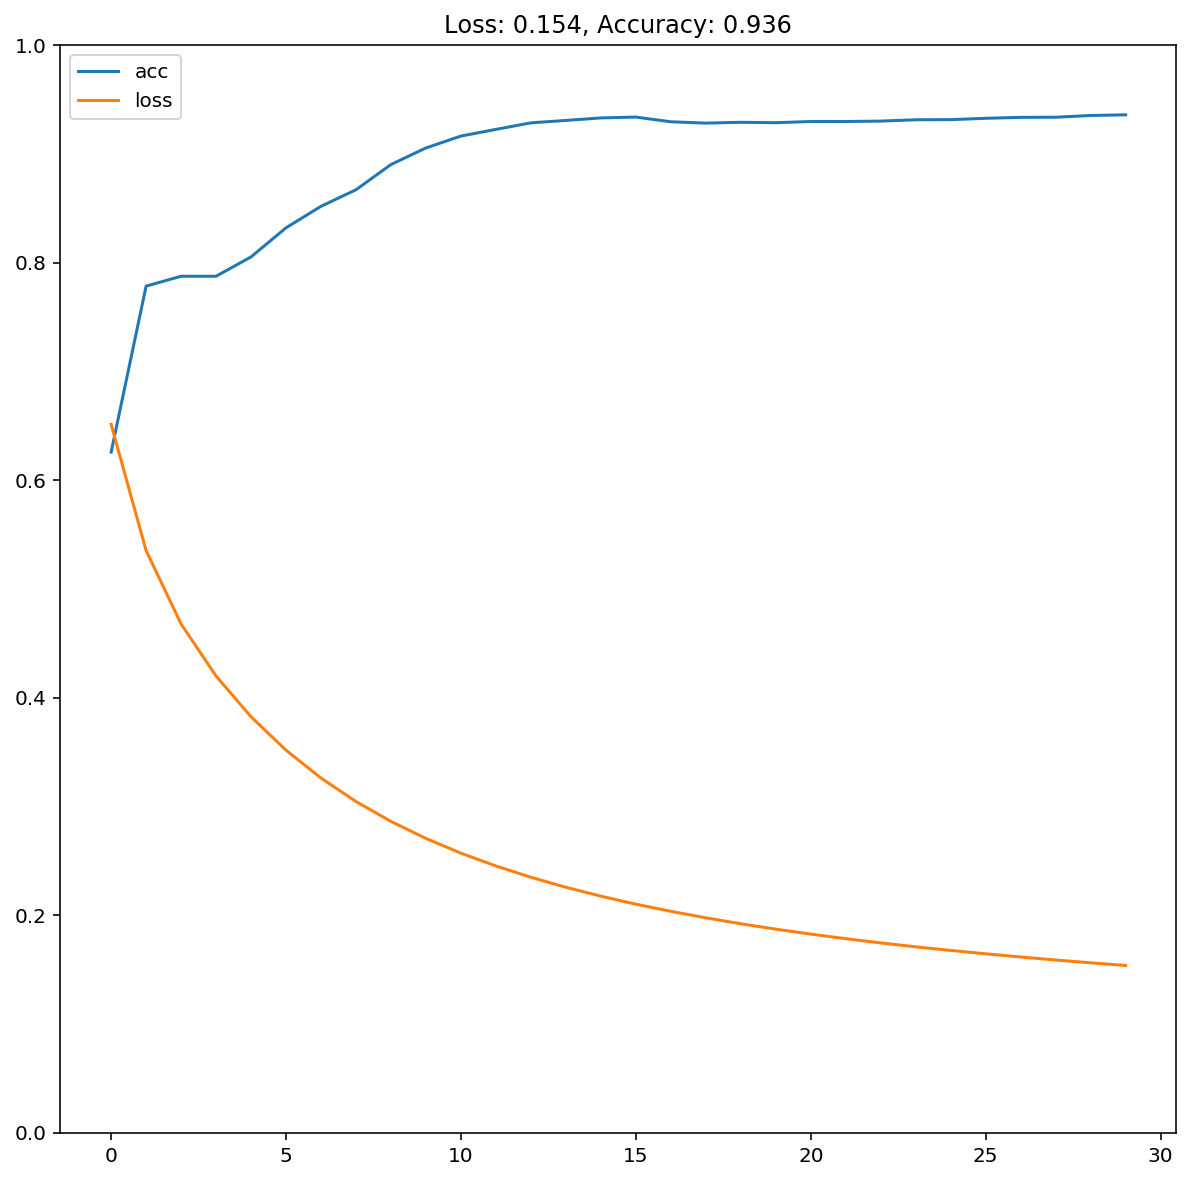

In [22]:
def nn_no_hidden_layers():
    model = Sequential()
    model.add(Dense(1, input_shape=(scaled_sig.shape[1],), activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

lr_model=nn_no_hidden_layers()
his_no_hidden_layers=lr_model.fit(scaled_sig, y_train, verbose=0, epochs=30)

plot_loss_accuracy(his_no_hidden_layers)

             precision    recall  f1-score   support

          0       0.94      0.96      0.95     15810
          1       0.85      0.79      0.82      4750

avg / total       0.92      0.92      0.92     20560



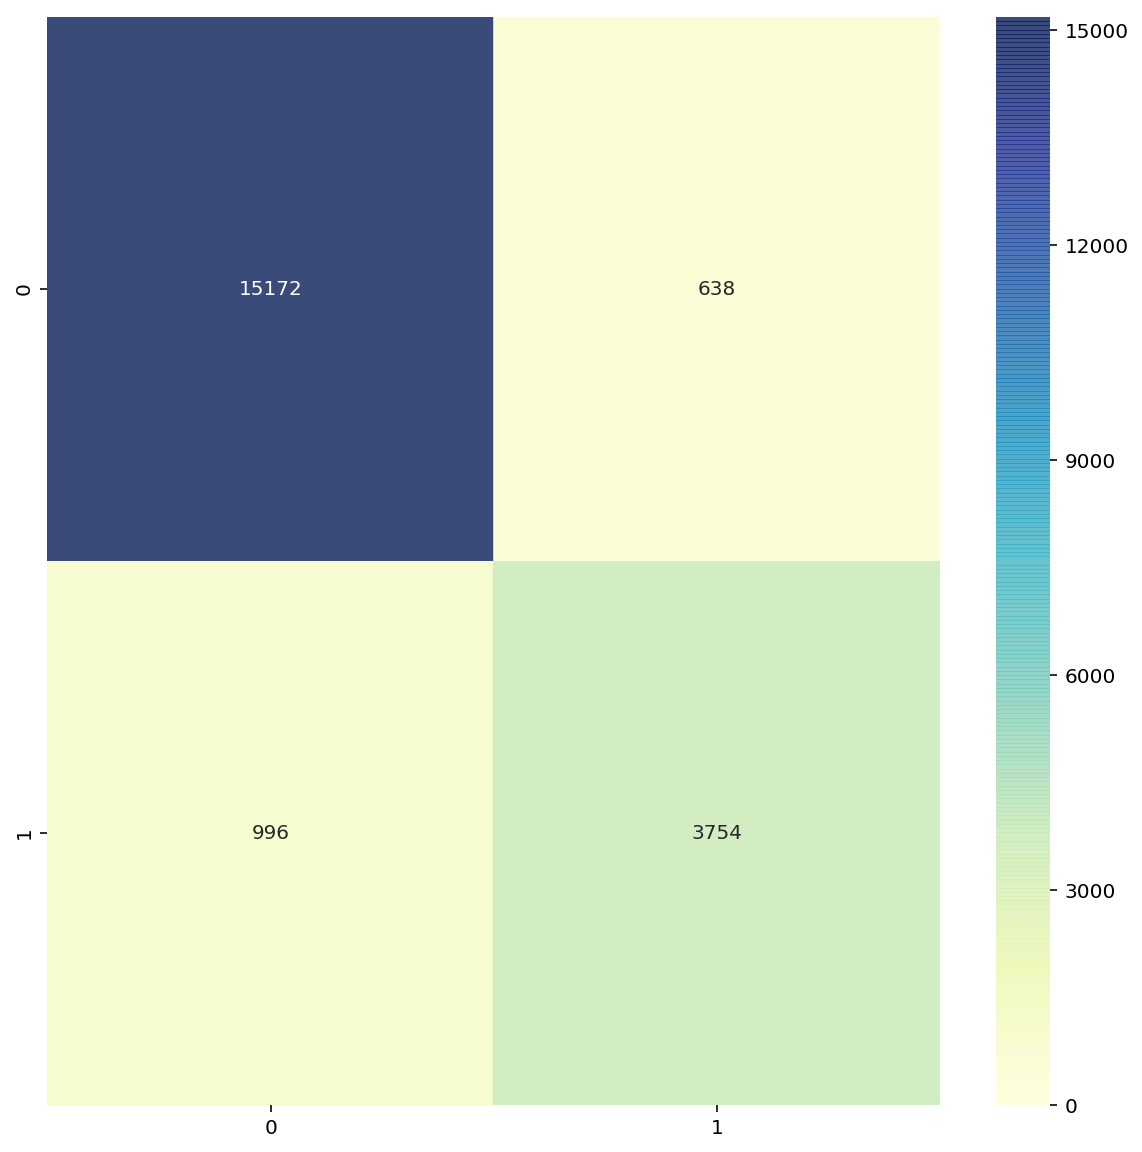

In [23]:
y_pred_shallow = lr_model.predict_classes(scaled_test_sig, verbose=0)
print(classification_report(y_test, y_pred_shallow))
plot_confusion_matrix(scaled_test_sig, y_test, y_pred_shallow)

In [24]:
new_X, new_y = shuffle(scaled_test_sig, y_test, random_state=0)
model = KerasClassifier(build_fn=nn_no_hidden_layers, epochs=5, verbose=0)
scores = cross_val_score(model, new_X, new_y, cv=5)

print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[0.9036965  0.90004864 0.88521401 0.88715953 0.91609922]
Accuracy: 89.84% (+/- 2.27%)


Standard deviation too high!

# Getting Deep

<Figure size 720x720 with 0 Axes>

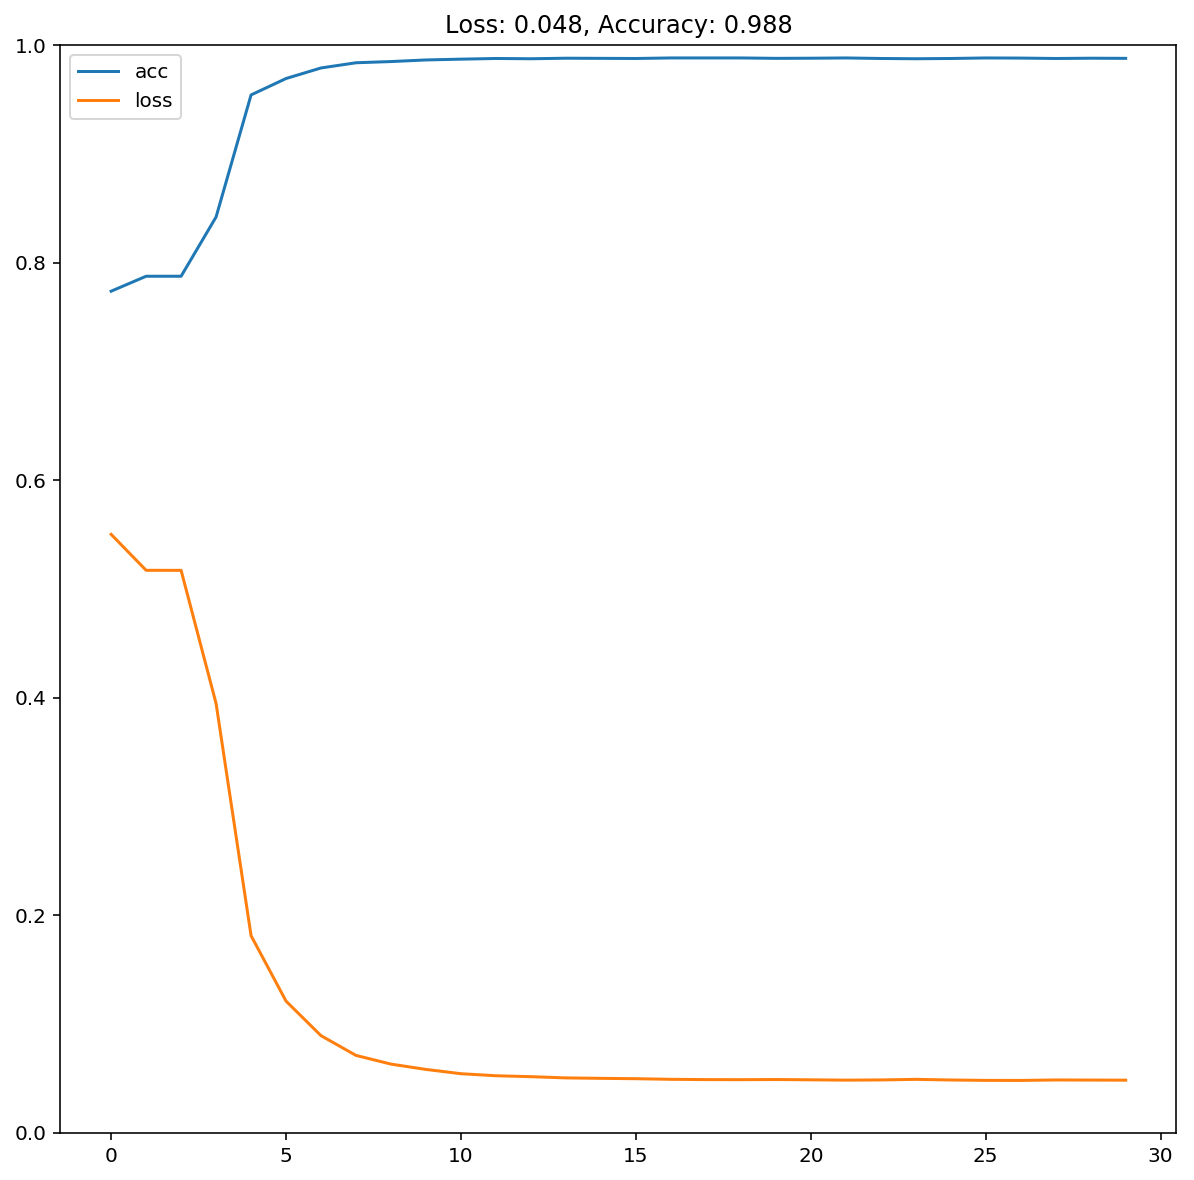

In [25]:
def five_hidden_layers():
    model = Sequential()
    model.add(Dense(128, input_shape=(scaled_sig.shape[1],), activation='sigmoid'))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

deep_model = five_hidden_layers()
deep_history = deep_model.fit(scaled_sig, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

             precision    recall  f1-score   support

          0       0.99      0.97      0.98     15810
          1       0.91      0.96      0.94      4750

avg / total       0.97      0.97      0.97     20560



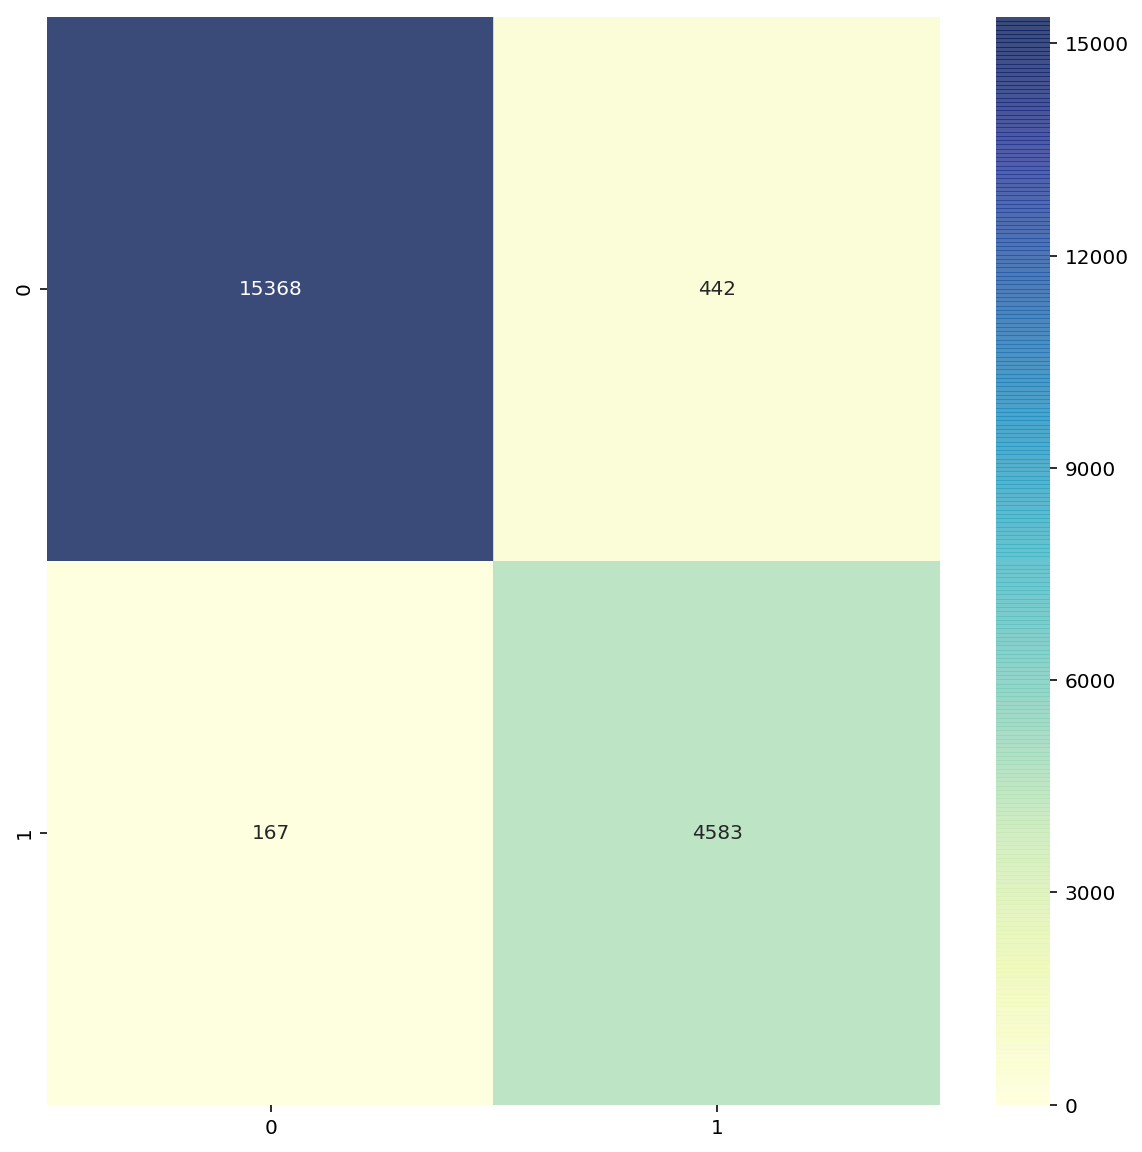

In [26]:
y_pred_deep  =  deep_model.predict_classes(scaled_test_sig, verbose=0)
print(classification_report(y_test, y_pred_deep))
plot_confusion_matrix(scaled_test_sig, y_test, y_pred_deep)

In [27]:
new_X, new_y = shuffle(scaled_test_sig, y_test, random_state=0)
model_deep = KerasClassifier(build_fn=five_hidden_layers, epochs=5, verbose=0)
scores_deep = cross_val_score(model_deep, new_X, new_y, cv=5)

print(scores_deep)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores_deep.mean(), 100*scores_deep.std()*2))

[0.98929961 0.98881323 0.98905642 0.99027237 0.98735409]
Accuracy: 98.90% (+/- 0.19%)


# Deeper Model

Epoch 1/30
8143/8143 [==============================] - 2s 219us/step - loss: 0.1210 - acc: 0.9667
Epoch 2/30
8143/8143 [==============================] - 1s 90us/step - loss: 0.0553 - acc: 0.9876
Epoch 3/30
8143/8143 [==============================] - 1s 78us/step - loss: 0.0706 - acc: 0.9802
Epoch 4/30
8143/8143 [==============================] - 1s 80us/step - loss: 0.0415 - acc: 0.9886
Epoch 5/30
8143/8143 [==============================] - 1s 95us/step - loss: 0.0379 - acc: 0.9885
Epoch 6/30
8143/8143 [==============================] - 1s 84us/step - loss: 0.0472 - acc: 0.9858
Epoch 7/30
8143/8143 [==============================] - 1s 85us/step - loss: 0.0357 - acc: 0.9878
Epoch 8/30
8143/8143 [==============================] - 1s 82us/step - loss: 0.0369 - acc: 0.9887
Epoch 9/30
8143/8143 [==============================] - 1s 98us/step - loss: 0.0323 - acc: 0.9898
Epoch 10/30
8143/8143 [==============================] - 1s 82us/step - loss: 0.0354 - acc: 0.9886
Epoch 11/30
8143/8

<Figure size 720x720 with 0 Axes>

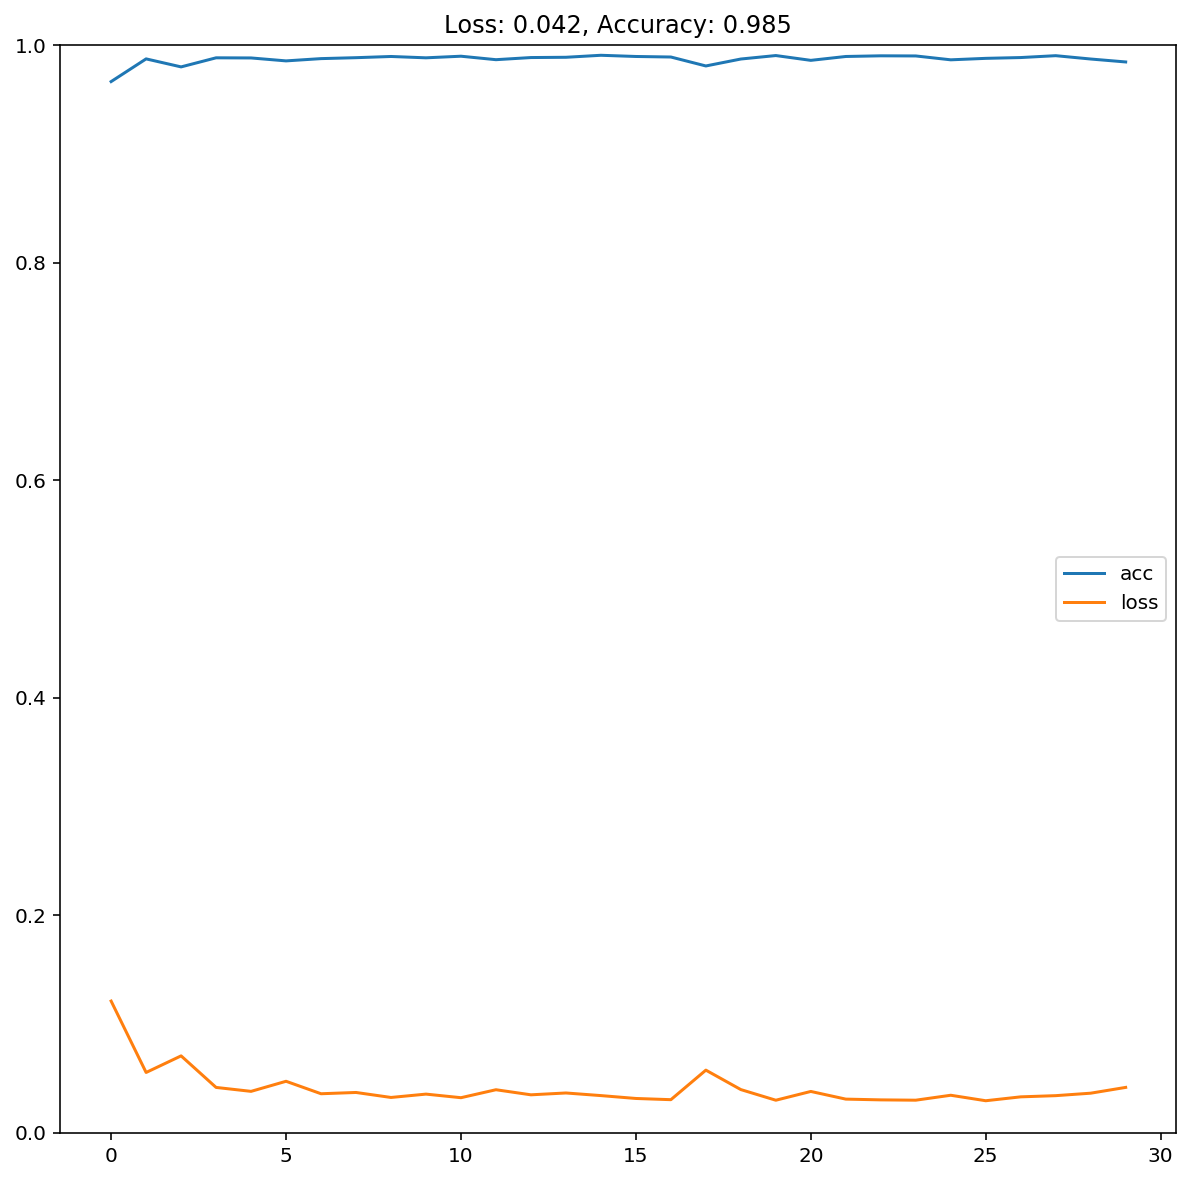

In [28]:
def ten_hidden_layers():
    model = Sequential()
    model.add(Dense(128, input_shape=(scaled_tanh.shape[1],), activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

deeper_model = ten_hidden_layers()
deeper_history = deeper_model.fit(scaled_tanh, y_train, verbose=1, epochs=30)
plot_loss_accuracy(deeper_history)

             precision    recall  f1-score   support

          0       0.98      0.99      0.98     15810
          1       0.96      0.93      0.94      4750

avg / total       0.97      0.97      0.97     20560



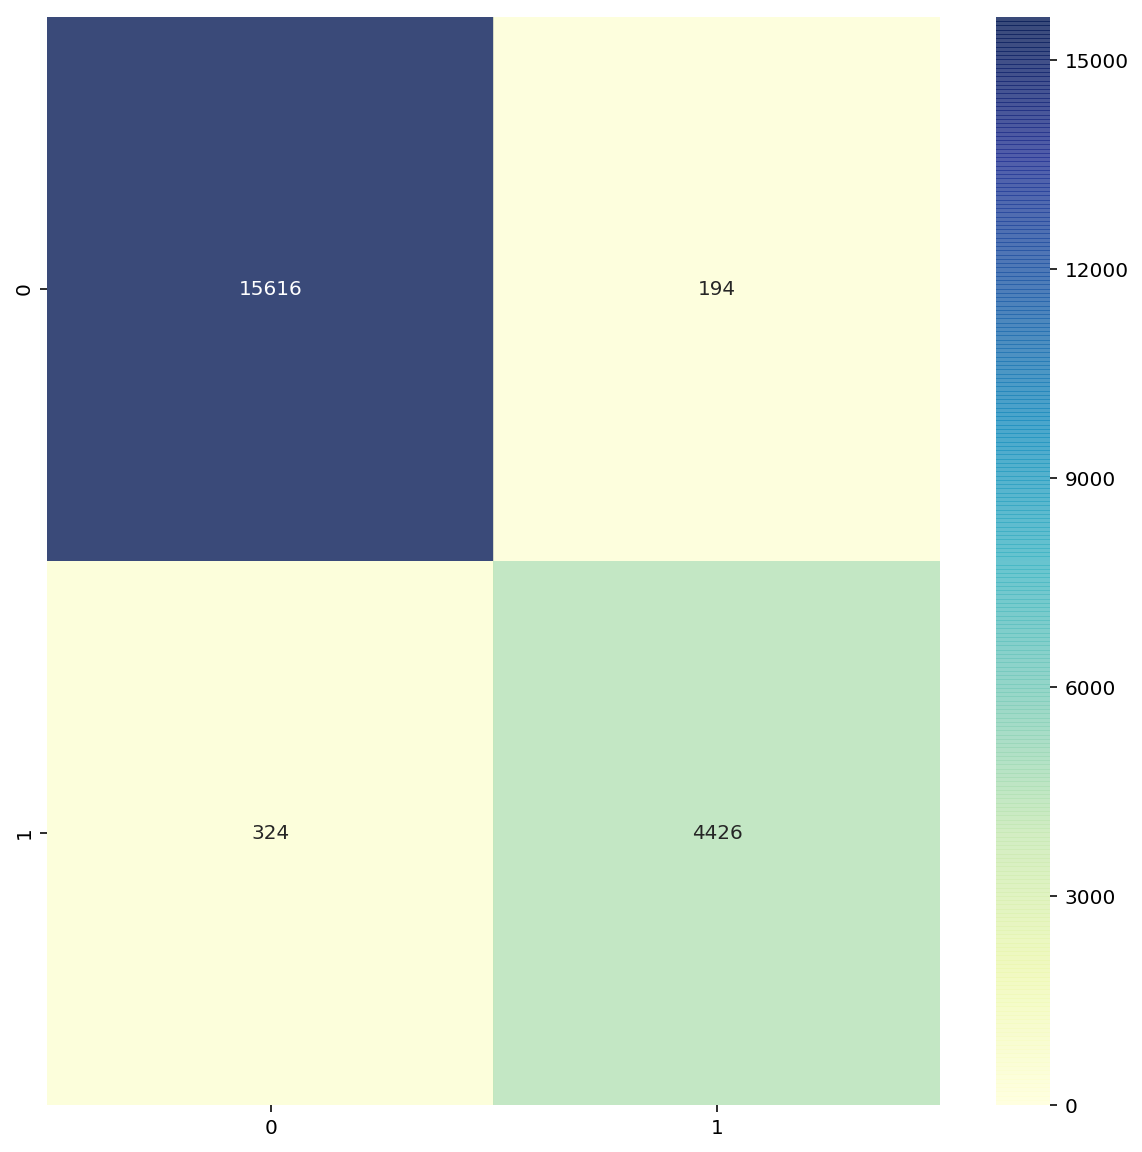

In [29]:
y_pred_deeper = deeper_model.predict_classes(scaled_test_tanh, verbose=0)
print(classification_report(y_test, y_pred_deeper))
plot_confusion_matrix(scaled_test_tanh, y_test, y_pred_deeper)

In [30]:
new_X, new_y = shuffle(scaled_test_tanh, y_test, random_state=0)
model_deeper = KerasClassifier(build_fn=ten_hidden_layers, epochs=5, verbose=0)
scores_deeper = cross_val_score(model_deeper, new_X, new_y, cv=5)

print(scores_deeper)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores_deeper.mean(), 100*scores_deeper.std()*2))

[0.98832685 0.9895428  0.98881323 0.99173152 0.98662451]
Accuracy: 98.90% (+/- 0.33%)


In [31]:
d = [["Logistic_Regression", score_lr, None],
     ["NN_Zero_Hidden_Layers", 100*scores.mean(), 100*scores.std()*2], 
     ["NN_Five_Hidden_Layers", 100*scores_deep.mean(), 100*scores_deep.std()*2],
     ["NN_Ten_Hidden_Layers", 100*scores_deeper.mean(), 100*scores_deeper.std()*2]]
df_score = pd.DataFrame(data=d, columns=["Method", "Accuracy", "Std"])
df_score.set_index('Method', inplace=True)
df_score

,Accuracy,Std
Method,,
Logistic_Regression,96.541829,NaN
NN_Zero_Hidden_Layers,89.844358,2.270229
NN_Five_Hidden_Layers,98.895914,0.188626
NN_Ten_Hidden_Layers,98.900778,0.333304


In [33]:
lr_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred).ravel()).values/len(y_test)*100
shallow_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_shallow).ravel()).values/len(y_test)*100
deep_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_deep).ravel()).values/len(y_test)*100
deeper_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_deeper).ravel()).values/len(y_test)*100

dd = [["Logistic_Regression", lr_matrix[0][0], lr_matrix[1][0], lr_matrix[2][0], lr_matrix[3][0]],
     ["No_Hidden_Layers", shallow_matrix[0][0], shallow_matrix[1][0], shallow_matrix[2][0], shallow_matrix[3][0]], 
     ["Five_Hidden_Layers", deep_matrix[0][0], deep_matrix[1][0], deep_matrix[2][0], deep_matrix[3][0]],
     ["Ten_Hidden_Layers", deeper_matrix[0][0], deeper_matrix[1][0], deeper_matrix[2][0], deeper_matrix[3][0]]]
df_conf = pd.DataFrame(data=dd, columns=["Method", 
                                         "True_Positive(%)", 
                                         "False_Positive(%)", 
                                         "False_Negative(%)",
                                         "True_Negative(%)"])
df_conf.set_index('Method', inplace=True)
df_conf


,True_Positive(%),False_Positive(%),False_Negative(%),True_Negative(%)
Method,,,,
Logistic_Regression,75.189689,1.707198,1.750973,21.352140
No_Hidden_Layers,73.793774,3.103113,4.844358,18.258755
Five_Hidden_Layers,74.747082,2.149805,0.812257,22.290856
Ten_Hidden_Layers,75.953307,0.943580,1.575875,21.527237


# Remarks
Logistic regression seems to return a initial good model for this application (from the pair plots it looks that data might be linearly separable. 

Accuracy of deep models looks better than accurary of shallow model. However, I need to optimize (fine tune) the deep and deeper models. 

Normalizing the input features helped reducing overfitting of the deep models. 

The deeper model has higher accuracy of all but not too different from the deep model. 

This is work in progress and neither model has been completely fine tune